## Gluacoma detection on Imbalanced dataset after using GAN

In [1]:
#Importing all the libraries
import warnings
warnings.filterwarnings('ignore')
import tqdm as tqdm
from skimage import io

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


import numpy as np
import pandas as pd 
import os
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model
%matplotlib inline

In [2]:
#Reading only the positive images
image_directory = r'C:\Users\nithu\Documents\Project\Gluacoma Detection\New folder\Fundus_Train_Val_Data\Fundus_Combined\Positive/'
dataset = []
IMAGE_SIZE = (200,200)
from PIL import Image
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        #Reading the image
        image = imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        #Resizing the image
        image = image.resize((IMAGE_SIZE[0],IMAGE_SIZE[1]))
        dataset.append(np.array(image))

x = np.array(dataset)

In [3]:
X_image_train_stacked = x  

In [4]:
#Building the GAN model

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt


trainX = X_image_train_stacked
#trainy = y_train
#testX = X_image_test_stacked
#testy = y_test


#Discriminator model
def define_discriminator(in_shape=(200,200,3)):
    model = Sequential()
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) 
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten()) 
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) 
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

test_discr = define_discriminator()
print("discriminator")
print(test_discr.summary())


#Generator model
def define_generator(latent_dim):    
    model = Sequential()
    n_nodes = 128 * 50 * 50  
    model.add(Dense(n_nodes, input_dim=latent_dim)) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((50, 50, 128)))  
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) 
    return model  

test_gen = define_generator(100)
print("Generator")
print(test_gen.summary())


# defining the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    discriminator.trainable = False      #Discriminator is trained separately. So set to not trainable.
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


# 
def load_real_samples():
    trainX = X_image_train_stacked
    # Convert to float and scale.
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5         #Generator uses tanh activation so rescale
    return X


#For each real image we assign a label 1 and for fake we assign label 0
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1)) 
    return X, y

# generate n_samples number of latent vectors (random noise) as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

#Use the above latent point generator to generate latent points.
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake.
    y = zeros((n_samples, 1))  
    return X, y

# training the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=32):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)  
    
    for i in range(n_epochs):
        for j in range(bat_per_epo):
    
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
        
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)  
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
    g_model.save('cifar_generator_250epochs.h5')

###################################################################

#Size of random array (latent_dim)
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=500)

# load the generator model and generate images
from keras.models import load_model
from numpy.random import randn


# load model
model = load_model('cifar_generator_250epochs.h5') 
# generate images
latent_points = generate_latent_points(100, 25)  
# generate images
X = model.predict(latent_points)

discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 100, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 50, 128)       0         
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dropout (Dropout)           (None, 320000)            0         
                                                                 
 dense (Dense)               (None, 1)    

KeyboardInterrupt: 

### Saving the generated images in pickle file in array format 

In [5]:
import pickle

file=open("test.pickle","wb")
pickle.dump(x,file)
file.close()

### Opening Pickle file

In [2]:
#Loading the data from the pickle file
X_positive_generated=pickle.load(open("test.pickle","rb"))

In [3]:
X_positive_generated.shape

(150, 200, 200, 3)

In [4]:
# scale from [-1,1] to [0,1]
X_positive_generated = (X_positive_generated + 1) / 2.0

import numpy as np
#Converting to a scale of [0,255]
X_positive_generated = (X_positive_generated*255).astype(np.uint8)

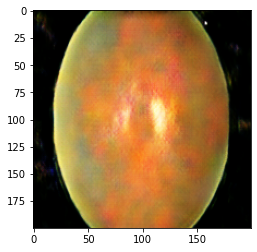

In [5]:
#plotting the generated image
import matplotlib.pyplot as plt
plt.imshow(X_positive_generated[4])

In [6]:
#Reading and resizing the images
import os
from tqdm import tqdm
import cv2
DATADIR = r'C:\Users\nithu\Documents\Project\Gluacoma Detection\New folder\Fundus_Train_Val_Data\Fundus_Combined'

CATEGORIES = ["Positive", "Negative"]

IMAGE_SIZE = (200,200)
training_data = []
Class = []
def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)[1:]):  
            img_array = cv2.imread(os.path.join(path,img))  
            new_array = cv2.resize(img_array, (IMAGE_SIZE[0], IMAGE_SIZE[1]))  

                
            training_data.append(new_array)  
            if category == 'Positive':
                Class.append(1)
            else:
                Class.append(0)

create_training_data()

100%|████████████████████████████████████████████████████████████████████████████████| 481/481 [00:34<00:00, 14.03it/s]


In [7]:
#Converting the list of images to array
training_data = np.array(training_data)
#Storing the classes of the generated images as 1 since all images generated through gan are positive
for i in range(len(X_positive_generated)):
    Class.append(1)

In [8]:
training_data.shape,X_positive_generated.shape

((647, 200, 200, 3), (150, 200, 200, 3))

In [9]:
#Stacking both the org images and generated images
new_train_data=np.vstack((training_data,X_positive_generated))

#Normalising the images
new_train_data=new_train_data/255
new_train_data.shape

(797, 200, 200, 3)

In [10]:
#converting the data into a dataframe
df = pd.DataFrame({'Images': new_train_data.tolist(),
                  'Class': Class})

In [11]:
df['Class'].value_counts()

0    481
1    316
Name: Class, dtype: int64

In [12]:
x = df['Images']
y = df['Class']

#Splitting the data
from sklearn.model_selection import train_test_split

x_temp, x_test, y_temp, y_test = train_test_split(x,y,test_size=0.2,train_size=0.8)
x_train, x_validation, y_train, y_validation = train_test_split(x_temp,y_temp,test_size = 0.2,train_size =0.80)

In [13]:
y_train.value_counts()

0    319
1    190
Name: Class, dtype: int64

In [14]:
y_test.value_counts()

0    91
1    69
Name: Class, dtype: int64

In [15]:
y_validation.value_counts()

0    71
1    57
Name: Class, dtype: int64

In [16]:
#Converting into numpy arrays
X_image_train_stacked = np.stack(x_train.values)
X_image_validation_stacked = np.stack(x_validation.values)
X_image_test_stacked = np.stack(x_test.values)

In [17]:
#Training the model
model = Sequential([layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(),
                    
  layers.Flatten(),
  layers.Dense(256, activation='relu'),                
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
              
hist=model.fit(X_image_train_stacked, y_train, epochs=10, validation_data=(X_image_validation_stacked,y_validation)) 

Epoch 1/10
16/16 [==============================] - 16s 877ms/step - loss: 0.5105 - accuracy: 0.7819 - val_loss: 0.5448 - val_accuracy: 0.7344
Epoch 2/10
16/16 [==============================] - 13s 831ms/step - loss: 0.4460 - accuracy: 0.8075 - val_loss: 0.5601 - val_accuracy: 0.7344
Epoch 3/10
16/16 [==============================] - 13s 827ms/step - loss: 0.4426 - accuracy: 0.8114 - val_loss: 0.5556 - val_accuracy: 0.7344
Epoch 4/10
16/16 [==============================] - 13s 839ms/step - loss: 0.4481 - accuracy: 0.8094 - val_loss: 0.5439 - val_accuracy: 0.7344
Epoch 5/10
16/16 [==============================] - 13s 849ms/step - loss: 0.4355 - accuracy: 0.8173 - val_loss: 0.5707 - val_accuracy: 0.7344
Epoch 6/10
16/16 [==============================] - 14s 853ms/step - loss: 0.4315 - accuracy: 0.8134 - val_loss: 0.5763 - val_accuracy: 0.7344
Epoch 7/10
16/16 [==============================] - 13s 829ms/step - loss: 0.4497 - accuracy: 0.8094 - val_loss: 0.5652 - val_accuracy: 0.7344

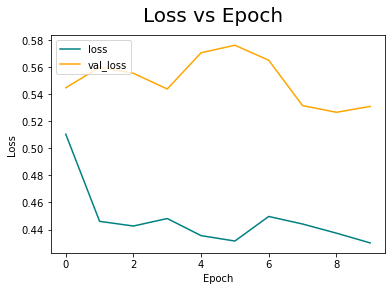

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss vs Epoch', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

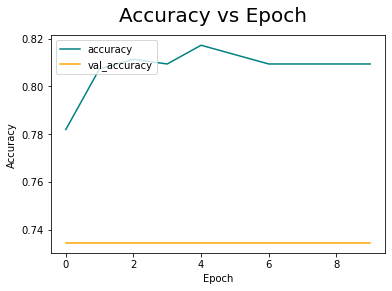

In [19]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy vs Epoch', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

In [20]:
#Evaluating the accuracy of the model
model.evaluate(X_image_test_stacked,y_test)

5/5 [==============================] - 1s 167ms/step - loss: 0.4538 - accuracy: 0.7812


[0.453810453414917, 0.78125]

In [21]:
#Predicting fot the test data
y_pred = model.predict(X_image_test_stacked)
y_pred_conv = []
for i in y_pred:
    if i[0] > i[1]:
        y_pred_conv.append(0)
    else:
        y_pred_conv.append(1)

5/5 [==============================] - 1s 177ms/step


ACCURACY SCORE:  0.78125
F1 score:  0.6601941747572816

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        91
           1       1.00      0.49      0.66        69

    accuracy                           0.78       160
   macro avg       0.86      0.75      0.75       160
weighted avg       0.84      0.78      0.76       160

CONFUSION MATRIX:


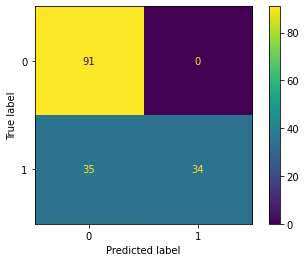

In [22]:
#Plotting the confusion matrix and classification report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

print("ACCURACY SCORE: ", accuracy_score(y_test,y_pred_conv))
print('F1 score: ', f1_score(y_test,y_pred_conv))
print()
print("CLASSIFICATION REPORT:")
print(classification_report(y_test,y_pred_conv))
a = confusion_matrix(y_test,y_pred_conv)
result = ConfusionMatrixDisplay(a)
print("CONFUSION MATRIX:")
result.plot()
plt.show()